In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define constants
INPUT_FILE = "/fast/nchandak/qaevals/lm-similarity/judge_w_gt_mmlu_pro_free_filtered/Qwen__Qwen2.5-7B-Instruct/samples.json"
OUTPUT_DIR = "/fast/nchandak/qaevals/lm-similarity/openrouter_judgments/mmlu_pro/Qwen__Qwen2.5-7B-Instruct"
OUTPUT_FILENAME = "openrouter_model_evals.json"

# Load the data
output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)

if os.path.exists(output_path):
    with open(output_path, 'r') as f:
        data = json.load(f)
    print(f"Loaded {len(data)} samples from {output_path}")
    print(json.dumps(data[0], indent=2))  # Print the first sample
    
    original_data = data
    # Filter data to keep only entries where response_deepseek-chat-v3-0324 exists and has length > 0
    filtered_data = []
    for item in original_data:
        response_field = "response_deepseek-chat-v3-0324"
        if response_field in item and item[response_field] and len(item[response_field]) > 0:
            filtered_data.append(item)
    
    print(f"Filtered to {len(filtered_data)} samples with non-empty deepseek-chat-v3-0324 responses")
    data = filtered_data
    
    # Save the filtered data if needed
    # with open(output_path, 'w') as f:
    #     json.dump(filtered_data, f, indent=2)


Loaded 8707 samples from /fast/nchandak/qaevals/lm-similarity/openrouter_judgments/mmlu_pro/Qwen__Qwen2.5-7B-Instruct/openrouter_model_evals.json
{
  "question_id": 73,
  "question": "_______ locate morality beyond the sphere of rationality in an emotional 'moral impulse' towards others.",
  "options": [
    "Ethical egoism",
    "Ethics of duty",
    "Postmodern ethics",
    "Consequentialist ethics",
    "Utilitarian ethics",
    "Deontological ethics",
    "Virtue ethics",
    "Ethics of care",
    "Ethics of rights",
    "Relativist ethics"
  ],
  "answer": "C",
  "answer_index": 2,
  "target": "Postmodern ethics",
  "filtered_resps": "Sentimentalism",
  "resps": " We refer to philosophical theories on ethics for help. Sentimentalism is a moral theory that locates morality beyond the sphere of rationality in an emotional 'moral impulse' towards others. The answer is (Sentimentalism)",
  "category": "business",
  "score_gemma-2-27b-it": "1",
  "score_Qwen2.5-32B-Instruct": "0",
  "s

In [3]:
# Load the samples file with model accuracy
model_name = os.path.basename(OUTPUT_DIR)  # Extract model name from OUTPUT_DIR
# Get the first file in the directory that matches the pattern
import glob
samples_dir = f"/fast/nchandak/qaevals/openllmleaderboard/{model_name}/"
samples_files = glob.glob(f"{samples_dir}samples_leaderboard_mmlu_pro_*.jsonl")
samples_file = samples_files[0] if samples_files else None
if not samples_file:
    print(f"No samples file found in {samples_dir}")

# Create a dictionary to map question_ids to their accuracy scores
question_id_to_acc = {}

# Read the JSONL file
overall_acc = 0
cnt = 0
with open(samples_file, 'r') as f:
    for line in f:
        sample = json.loads(line)
        # Extract question_id and accuracy
        question_id = sample.get("doc", {}).get("question_id")
        acc = sample.get("acc")
        overall_acc += acc
        cnt += 1
        if question_id is not None and acc is not None:
            question_id_to_acc[question_id] = float(acc)
        else :
            print(f"Question ID {question_id} has no accuracy")

print(f"Loaded {len(question_id_to_acc)} question_id to accuracy mappings")
print(f"Overall accuracy: {overall_acc/cnt*100:.2f}%")
# Add 'score_mcq' field to data based on question_id
for item in data:
    question_id = item.get("question_id")
    if question_id in question_id_to_acc:
        # Convert accuracy (which is likely 0 or 1) to string to match other score fields
        item["score_mcq"] = str(int(question_id_to_acc[question_id]))
    else:
        # If question_id not found, don't add the field
        print(f"Question ID {question_id} not found in question_id_to_acc")
        pass

# convert data to json for easy viewing
# with open("data.json", "w") as f:
#     json.dump(data, f, indent=2)

# Count how many items have the score_mcq field
count_with_mcq_score = sum(1 for item in data if "score_mcq" in item)
print(f"Added 'score_mcq' field to {count_with_mcq_score} out of {len(data)} items")

# Calculate MCQ accuracy
mcq_correct = sum(1 for item in data if item["score_mcq"] == "1")
mcq_accuracy = (mcq_correct / count_with_mcq_score * 100) if count_with_mcq_score > 0 else 0
print(f"MCQ accuracy: {mcq_correct}/{count_with_mcq_score} ({mcq_accuracy:.2f}%)")


Loaded 12032 question_id to accuracy mappings
Overall accuracy: 42.89%
Added 'score_mcq' field to 8574 out of 8574 items
MCQ accuracy: 3515/8574 (41.00%)


Agreements: {'gemma-2-27b-it': 89.82971775134126, 'Qwen2.5-32B-Instruct': 92.41894098437136, 'Llama-3.3-70B-Instruct': 92.55889899696757, 'Qwen2.5-72B-Instruct': 93.14205738278515, 'Meta-Llama-3.1-70B-Instruct': 92.3372988103569, 'qwen3-32b': 51.33333333333333, 'mcq': 58.44413342663868}
Accuracies: {'deepseek-chat-v3-0324': 45.0431537205505, 'gemma-2-27b-it': 43.83018427804991, 'Qwen2.5-32B-Instruct': 47.32913459295545, 'Llama-3.3-70B-Instruct': 47.63237695358059, 'Qwen2.5-72B-Instruct': 42.54723582925122, 'Meta-Llama-3.1-70B-Instruct': 45.264753907161186, 'qwen3-32b': 0.0, 'mcq': 40.99603452297644}

Accuracy by judge:
Llama-3.3-70B-Instruct: 47.63%
Qwen2.5-32B-Instruct: 47.33%
Meta-Llama-3.1-70B-Instruct: 45.26%
deepseek-chat-v3-0324: 45.04%
gemma-2-27b-it: 43.83%
Qwen2.5-72B-Instruct: 42.55%
mcq: 41.00%
qwen3-32b: 0.00%


/tmp/ipykernel_684908/1674578917.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Agreement (%)', y='Model', data=agreement_df, palette='viridis')


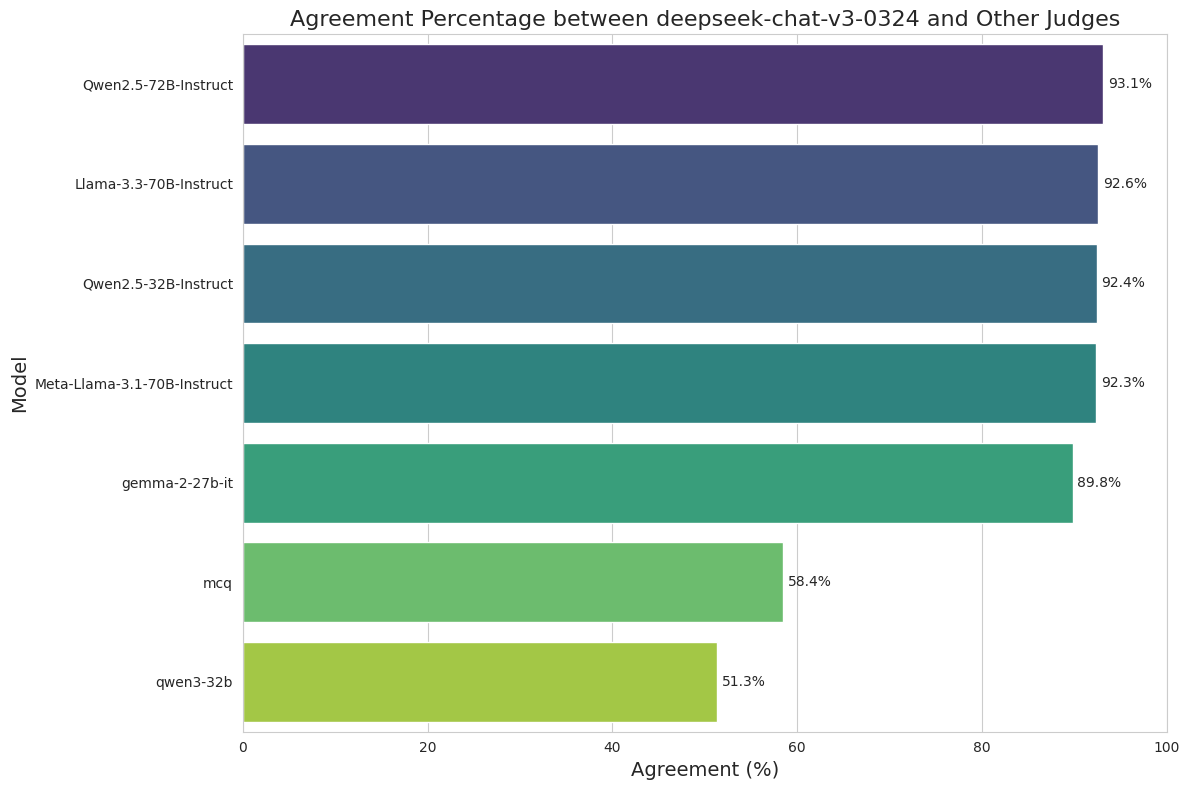

Agreement percentages with deepseek-chat-v3-0324:
Qwen2.5-72B-Instruct: 93.14%
Llama-3.3-70B-Instruct: 92.56%
Qwen2.5-32B-Instruct: 92.42%
Meta-Llama-3.1-70B-Instruct: 92.34%
gemma-2-27b-it: 89.83%
mcq: 58.44%
qwen3-32b: 51.33%


In [4]:
# Calculate agreement between deepseek and other judges
def calculate_agreement(data, reference_model="deepseek-chat-v3-0324"):
    """Calculate agreement percentage between reference model and other judges."""
    reference_field = f"score_{reference_model}"
    
    # Find all score fields
    score_fields = [field for field in data[0].keys() if field.startswith("score_")]
    
    # Calculate agreement percentages and accuracy for each model
    agreements = {}
    accuracies = {}
    
    # Calculate accuracy for reference model
    ref_correct = sum(1 for item in data if reference_field in item and item[reference_field] == "1")
    ref_total = sum(1 for item in data if reference_field in item)
    if ref_total > 0:
        accuracies[reference_model] = (ref_correct / ref_total) * 100
    
    for field in score_fields:
        if field == reference_field:
            continue
            
        model_name = field.replace("score_", "")
        agreement_count = 0
        valid_count = 0
        
        # Calculate accuracy for this model
        correct_count = sum(1 for item in data if field in item and item[field] == "1")
        total_count = sum(1 for item in data if field in item)
        if total_count > 0:
            accuracies[model_name] = (correct_count / total_count) * 100
        
        for item in data:
            # Only count if both scores exist
            if reference_field in item and field in item and item[reference_field] and item[field]:
                valid_count += 1
                if item[reference_field] == item[field]:
                    agreement_count += 1
        
        if valid_count > 0:
            agreements[model_name] = (agreement_count / valid_count) * 100
    
    print(f"Agreements: {agreements}")
    print(f"Accuracies: {accuracies}")
    
    # Print accuracy for each judge
    print("\nAccuracy by judge:")
    for model, accuracy in sorted(accuracies.items(), key=lambda x: x[1], reverse=True):
        print(f"{model}: {accuracy:.2f}%")
    
    return agreements

# Calculate agreement percentages
agreement_percentages = calculate_agreement(data)

# Convert to DataFrame for easier plotting
agreement_df = pd.DataFrame({
    'Model': list(agreement_percentages.keys()),
    'Agreement (%)': list(agreement_percentages.values())
})

# Sort by agreement percentage for better visualization
agreement_df = agreement_df.sort_values('Agreement (%)', ascending=False)

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
ax = sns.barplot(x='Agreement (%)', y='Model', data=agreement_df, palette='viridis')

# Add percentage labels to the bars
for i, v in enumerate(agreement_df['Agreement (%)']):
    ax.text(v + 0.5, i, f"{v:.1f}%", va='center')

# Set title and labels
plt.title('Agreement Percentage between deepseek-chat-v3-0324 and Other Judges', fontsize=16)
plt.xlabel('Agreement (%)', fontsize=14)
plt.ylabel('Model', fontsize=14)
plt.xlim(0, 100)  # Set x-axis limits from 0 to 100%
plt.tight_layout()

# Show the plot
plt.show()

# Print the agreement percentages
print("Agreement percentages with deepseek-chat-v3-0324:")
for model, agreement in sorted(agreement_percentages.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {agreement:.2f}%")
